<img src='../img/dust_banner.png' alt='Training school and workshop on dust' align='center' width='100%'></img>

<br>

# 04 - Practical exercise - Solution - Model I

### About

> In [Practical exercise 2](../05_practicals/52_exercise.ipynb) we used satellite data to look at global seasonal cycles. Today, we will once again broaden our perspective and use model data to analyse the annual cycle and seasonality of dust and aerosols at a specific location.

### Tasks

#### 1. Brainstorm
  * What data can be used for analysing the annual cycle and patterns of dust?
  * What aggregation level is required?
  * What are some differences between forecast and reanalysis model data? 

#### 2. Download and plot time-series of AERONET data for *Granada, Spain* in 2021
  * **Hint** 
    * [AERONET - Example notebook](../04_data_workflows/42_groundbased_observations/421_AERONET.ipynb)
    * you can select daily aggregates of the station observations with setting `AVG=20`
    * For the AERONET plot, you just need to plot the `AOD_500nm` data and the `500-870nm Angstrom exponent`.
    * Optional: You can also add a horizontal line that shows the cut-off value where the Angstrom Exponent <0.6 indicates dust.
  * **Interpret the results:**
    * Have there been other times in 2021 with increased AOD values?
    * If yes, how could you find out if the increase in AOD is caused by dust? Try to find out by visualizing the AOD time-series together with another parameter from the AERONET data.
    * [MSG SEVIRI Dust RGB](https://sds-was.aemet.es/forecast-products/dust-observations/msg-2013-eumetsat) and [MODIS RGB](https://worldview.earthdata.nasa.gov/) quick looks might be helpful to get a more complete picture of other events that might have happened in 2021.


#### 3. Download CAMS global reanalysis (EAC4) and select 2021 time-series for *Granada, Spain*
  * **Hint**
    * [CAMS global reanalysis - Example notebook](../04_data_workflows/43_model_data/432_CAMS_global_reanalysis_duaod_load_browse.ipynb)
    * [Data access](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-reanalysis-eac4?tab=form) with the following specifications:
    > Variable on single levels: `Dust aerosol optical depth at 550 nm` <br>
    > Date: `Start=2021-01-01`, `End=2021-12-31` <br>
    > Time: `[00:00, 03:00, 06:00, 09:00, 12:00, 15:00, 18:00, 21:00]` <br>
    > Restricted area: `N: 71, W: -22, E: 43, S: 28` <br>
    >Format: `netCDF` <br>
    * With the xarray function `sel()` and keyword argument `method='nearest'` you can select data based on coordinate information
    * We also recommend you to transform your xarray.DataArray into a pandas.DataFrame with the function `to_dataframe()`

#### 4. Resample AERONET observations and CAMS reanalysis (EAC4) time-series for *Granada, Spain* in 2021 and plot monthly aggregates in one plot
  * Load the time-series of daily aggregated AERONET observations and CAMS reanalysis (EAC4) for Granada, Spain in 2021, resample the values to monthly averages and plot the monthly averaged values together in one plot
  * **Hint** 
    * Make use of AERONET `index` and `time` columns to create a `DateTimeIndex` in order to resample the observations to a monthly temporal resolution
    * you have to combine the two columns `index` and `time` as one string variable
    * you can use the pandas function `to_datetime()` to create a `DateTimeIndex` and the function `resample().mean()` to resample and average the time-series to a given temporal resolution 
  * **Question to reflect on**
    * How many row entries does the resampled data frame have?
    
#### 5. BONUS: Extract a time-series from the monthly gridded Dust AOD C3S aerosol properties data for *Granada, Spain* from METOP-C and add it to the plot. 
  * Use the same download specifications or the same data in Practical 2

#### 6. Interpret the plotting results
  * Do the monthly patterns of AERONET observations and CAMS reanalysis look similar?
  * How do they differ?

### Module outline
* [1 - Select latitude / longitude values for Granada, Spain](#select_lat_lon)
* [2 - Download and plot time-series of AERONET data](#download_aeronet)
* [3 - Download CAMS global reanalysis (EAC4) and select 2021 time-series for Granada, Spain](#download_cams_reanalysis)
* [4 - Resample AERONET and CAMS reanalysis (EAC4) time-series for Granada, Spain in 2021 and plot monthly aggregates in one plot](#aeronet_cams_ts)
* [5 - BONUS: Extract a time-series from the monthly gridded C3S aerosol properties data for Granada, Spain and add it to the plot](#add_iasi_ts)

<hr>

##### Load required libraries

In [1]:
import xarray as xr
import pandas as pd
import wget
from datetime import datetime

from IPython.display import HTML

import matplotlib.pyplot as pl
import matplotlib.colors
from matplotlib.cm import get_cmap
from matplotlib import animation
from matplotlib.axes import Axes

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

##### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

<br>

### <a id='select_lat_lon'></a>1. Select latitude / longitude values for `Granada`

You can see an overview of all available AERONET Site Names [here](https://aeronet.gsfc.nasa.gov/cgi-bin/draw_map_display_aod_v3?long1=-180&long2=180&lat1=-90&lat2=90&multiplier=2&what_map=4&nachal=1&formatter=0&level=3&place_code=10&place_limit=0).

In [3]:
lat = 37.164
lon = -3.605

<br>

### <a id='download_aeronet'></a>2. Download and plot time-series of AERONET data

As a first step, let us create a Python dictionary in which we store all the parameters we would like to use for the request as dictionary keys. You can initiate a dictionary with curled brackets `{}`. Below, we specify the following parameters:
* `endpoint`: Endpoint of the AERONET web service
* `station`: Name of the AERONET station
* `year`: year 1 of interest
* `month`: month 1 of interest
* `day`: day 1 of interest
* `year2`: year 2 of interest
* `month2`: month 2 of interest
* `day2`: day 2 of interest
* `AOD15`: data type, other options include `AOD10`, `AOD20`, etc.
* `AVG`: data format, `AVG=10` - all points, `AVG=20` - daily averages

The keywords below are those we will need for requesting daily averages (`AVG=20`) of Aerosol Optical Depth Level 1.5 data for the station Granada from 1 January 2021 to 31 December 2021.

In [4]:
data_dict = {
    'endpoint': 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_v3',
    'station':'Granada',
    'year': 2021,
    'month': 1,
    'day': 1,
    'year2': 2021,
    'month2': 12,
    'day2': 31,
    'AOD15': 1,
    'AVG': 20
}


<br>

In a next step, we construct the final string for the wget request with the `format` function. You construct a string by adding the dictionary keys in curled brackets. At the end of the string, you provide the dictionary key informatoin to the string with the `format()` function. A print of the resulting url shows, that the format function replaced the information in the curled brackets with the data in the dictionary.

In [5]:
url = '{endpoint}?site={station}&year={year}&month={month}&day={day}&year2={year2}&month2={month2}&day2={day2}&AOD15={AOD15}&AVG={AVG}'.format(**data_dict)
url

'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_v3?site=Granada&year=2021&month=1&day=1&year2=2021&month2=12&day2=31&AOD15=1&AVG=20'

<br>

Now we are ready to request the data with the function `download()` from the wget Python library. You have to pass to the function the constructed url above together with a file path of where the downloaded that shall be stored.

In [6]:
#wget.download(url, './2021_granada_20.txt')

<br>

After we downloaded the station observations as `txt` file, we can open it with the pandas function `read_table()`. If you are using the file you downloaded yourself, please change the file path. We additonally set specific keyword arguments that allow us to specify the columns and rows of interest:
* `delimiter`: specify the delimiter in the text file, e.g. comma
* `header`: specify the index of the row that shall be set as header.
* `index_col`: specify the index of the column that shall be set as index

You see below that the resulting dataframe has 180 rows and 113 columns.

In [7]:
df = pd.read_table('../../eodata/dust/part2/2_observations/aeronet/2021_granada_20.txt', delimiter=',', header=[7], index_col=1)
df

,AERONET_Site,Time(hh:mm:ss),Day_of_Year,AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_865nm,AOD_779nm,AOD_675nm,AOD_667nm,...,N[440-675_Angstrom_Exponent],N[500-870_Angstrom_Exponent],N[340-440_Angstrom_Exponent],N[440-675_Angstrom_Exponent[Polar]],Data_Quality_Level,AERONET_Instrument_Number,AERONET_Site_Name,Site_Latitude(Degrees),Site_Longitude(Degrees),Site_Elevation(m)<br>
Date(dd:mm:yyyy),,,,,,,,,,,,,,,,,,,,,
01:01:2021,Granada,12:00:00,1.0,0.008499,0.018013,0.022467,-999.0,-999.0,0.033328,-999.0,...,1.0,1.0,1.0,0.0,lev15,1094.0,Granada,37.164,-3.605,680.000000<br>
02:01:2021,Granada,12:00:00,2.0,0.005669,0.014561,0.018416,-999.0,-999.0,0.028165,-999.0,...,54.0,54.0,53.0,0.0,lev15,1094.0,Granada,37.164,-3.605,680.000000<br>
03:01:2021,Granada,12:00:00,3.0,0.003792,0.011665,0.015136,-999.0,-999.0,0.023541,-999.0,...,130.0,130.0,130.0,0.0,lev15,1094.0,Granada,37.164,-3.605,680.000000<br>
04:01:2021,Granada,12:00:00,4.0,0.007229,0.017568,0.022374,-999.0,-999.0,0.033778,-999.0,...,130.0,130.0,130.0,0.0,lev15,1094.0,Granada,37.164,-3.605,680.000000<br>
05:01:2021,Granada,12:00:00,5.0,0.008397,0.018155,0.022574,-999.0,-999.0,0.033482,-999.0,...,37.0,37.0,37.0,0.0,lev15,1094.0,Granada,37.164,-3.605,680.000000<br>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16:12:2021,Granada,12:00:00,350.0,0.017004,0.027091,0.035307,-999.0,-999.0,0.046893,-999.0,...,79.0,79.0,79.0,0.0,lev15,751.0,Granada,37.164,-3.605,680.000000<br>
18:12:2021,Granada,12:00:00,352.0,0.066869,0.088777,0.099982,-999.0,-999.0,0.115510,-999.0,...,70.0,70.0,70.0,0.0,lev15,751.0,Granada,37.164,-3.605,680.000000<br>
19:12:2021,Granada,12:00:00,353.0,0.033000,0.044037,0.050401,-999.0,-999.0,0.057888,-999.0,...,90.0,90.0,90.0,0.0,lev15,751.0,Granada,37.164,-3.605,680.000000<br>


Now, we can inspect the entries in the loaded data frame a bit more. Above you see that the last entry is a NaN entry, which is best to drop with the function `dropna()`.

The next step is then to replace the entries with -999.0 and set them as NaN. We can use the function `replace()` to do so. 

In [8]:
df = df.dropna()
df = df.replace(-999.0, np.nan)
df

,AERONET_Site,Time(hh:mm:ss),Day_of_Year,AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_865nm,AOD_779nm,AOD_675nm,AOD_667nm,...,N[440-675_Angstrom_Exponent],N[500-870_Angstrom_Exponent],N[340-440_Angstrom_Exponent],N[440-675_Angstrom_Exponent[Polar]],Data_Quality_Level,AERONET_Instrument_Number,AERONET_Site_Name,Site_Latitude(Degrees),Site_Longitude(Degrees),Site_Elevation(m)<br>
Date(dd:mm:yyyy),,,,,,,,,,,,,,,,,,,,,
01:01:2021,Granada,12:00:00,1.0,0.008499,0.018013,0.022467,NaN,NaN,0.033328,NaN,...,1.0,1.0,1.0,0.0,lev15,1094.0,Granada,37.164,-3.605,680.000000<br>
02:01:2021,Granada,12:00:00,2.0,0.005669,0.014561,0.018416,NaN,NaN,0.028165,NaN,...,54.0,54.0,53.0,0.0,lev15,1094.0,Granada,37.164,-3.605,680.000000<br>
03:01:2021,Granada,12:00:00,3.0,0.003792,0.011665,0.015136,NaN,NaN,0.023541,NaN,...,130.0,130.0,130.0,0.0,lev15,1094.0,Granada,37.164,-3.605,680.000000<br>
04:01:2021,Granada,12:00:00,4.0,0.007229,0.017568,0.022374,NaN,NaN,0.033778,NaN,...,130.0,130.0,130.0,0.0,lev15,1094.0,Granada,37.164,-3.605,680.000000<br>
05:01:2021,Granada,12:00:00,5.0,0.008397,0.018155,0.022574,NaN,NaN,0.033482,NaN,...,37.0,37.0,37.0,0.0,lev15,1094.0,Granada,37.164,-3.605,680.000000<br>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15:12:2021,Granada,12:00:00,349.0,0.013097,0.019726,0.025072,NaN,NaN,0.030244,NaN,...,120.0,120.0,120.0,0.0,lev15,751.0,Granada,37.164,-3.605,680.000000<br>
16:12:2021,Granada,12:00:00,350.0,0.017004,0.027091,0.035307,NaN,NaN,0.046893,NaN,...,79.0,79.0,79.0,0.0,lev15,751.0,Granada,37.164,-3.605,680.000000<br>
18:12:2021,Granada,12:00:00,352.0,0.066869,0.088777,0.099982,NaN,NaN,0.115510,NaN,...,70.0,70.0,70.0,0.0,lev15,751.0,Granada,37.164,-3.605,680.000000<br>


Let us also filter out the single value from 2022. The following filter selects rows that contain `2021`.

In [9]:
df = df.filter(like='2021', axis=0)
df

,AERONET_Site,Time(hh:mm:ss),Day_of_Year,AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_865nm,AOD_779nm,AOD_675nm,AOD_667nm,...,N[440-675_Angstrom_Exponent],N[500-870_Angstrom_Exponent],N[340-440_Angstrom_Exponent],N[440-675_Angstrom_Exponent[Polar]],Data_Quality_Level,AERONET_Instrument_Number,AERONET_Site_Name,Site_Latitude(Degrees),Site_Longitude(Degrees),Site_Elevation(m)<br>
Date(dd:mm:yyyy),,,,,,,,,,,,,,,,,,,,,
01:01:2021,Granada,12:00:00,1.0,0.008499,0.018013,0.022467,NaN,NaN,0.033328,NaN,...,1.0,1.0,1.0,0.0,lev15,1094.0,Granada,37.164,-3.605,680.000000<br>
02:01:2021,Granada,12:00:00,2.0,0.005669,0.014561,0.018416,NaN,NaN,0.028165,NaN,...,54.0,54.0,53.0,0.0,lev15,1094.0,Granada,37.164,-3.605,680.000000<br>
03:01:2021,Granada,12:00:00,3.0,0.003792,0.011665,0.015136,NaN,NaN,0.023541,NaN,...,130.0,130.0,130.0,0.0,lev15,1094.0,Granada,37.164,-3.605,680.000000<br>
04:01:2021,Granada,12:00:00,4.0,0.007229,0.017568,0.022374,NaN,NaN,0.033778,NaN,...,130.0,130.0,130.0,0.0,lev15,1094.0,Granada,37.164,-3.605,680.000000<br>
05:01:2021,Granada,12:00:00,5.0,0.008397,0.018155,0.022574,NaN,NaN,0.033482,NaN,...,37.0,37.0,37.0,0.0,lev15,1094.0,Granada,37.164,-3.605,680.000000<br>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14:12:2021,Granada,12:00:00,348.0,0.010676,0.017292,0.022104,NaN,NaN,0.026201,NaN,...,121.0,122.0,121.0,0.0,lev15,751.0,Granada,37.164,-3.605,680.000000<br>
15:12:2021,Granada,12:00:00,349.0,0.013097,0.019726,0.025072,NaN,NaN,0.030244,NaN,...,120.0,120.0,120.0,0.0,lev15,751.0,Granada,37.164,-3.605,680.000000<br>
16:12:2021,Granada,12:00:00,350.0,0.017004,0.027091,0.035307,NaN,NaN,0.046893,NaN,...,79.0,79.0,79.0,0.0,lev15,751.0,Granada,37.164,-3.605,680.000000<br>


We can now plot the column `AOD_500nm` as time-series. Do we have observations every day?

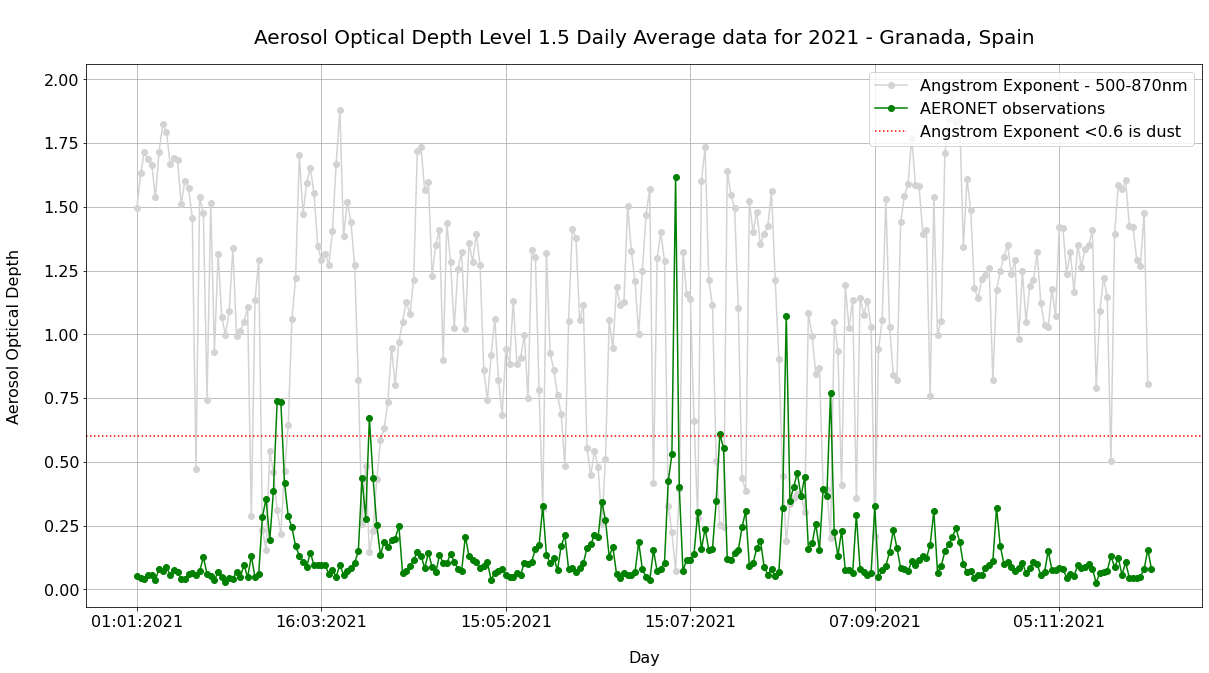

In [10]:
# Initiate a matplotlib figure
fig = plt.figure(figsize=(20,10))
ax=plt.axes()

# Select pandas dataframe columns and define a line plot for AOD and the Angstrom Exponent
df['500-870_Angstrom_Exponent'][:-1].plot(ax=ax, style='o-', color='lightgrey', label='Angstrom Exponent - 500-870nm')
df['AOD_500nm'].plot(ax=ax, style='o-', color='green', label='AERONET observations' )
plt.axhline(y=0.6, color='r', linestyle='dotted', label='Angstrom Exponent <0.6 is dust')

# Set title and axes lable information
plt.title('\nAerosol Optical Depth Level 1.5 Daily Average data for 2021 - Granada, Spain', fontsize=20, pad=20)
plt.ylabel('Aerosol Optical Depth\n', fontsize=16)
plt.xlabel('\nDay', fontsize=16)

# Format the axes ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add additionally a legend and grid to the plot
plt.legend(fontsize=16,loc=1)
plt.grid()

### <a id='download_cams_reanalysis'></a> 3. Download CAMS global reanalysis (EAC4) and select 2021 time-series for Granada, Spain

The `CDS Application Program Interface (CDS API)` is a Python library which allows you to access data from the ADS `programmatically`. In order to use the CDS API, follow the steps below:

* [Self-register](https://ads.atmosphere.copernicus.eu/#!/home) at the ADS registration page (if you do not have an account yet)
* [Login](https://ads.atmosphere.copernicus.eu/user/login) to the ADS portal and go to the [api-how-to page](https://ads.atmosphere.copernicus.eu/api-how-to)
* Copy the CDS API key displayed in the black terminal window and replace the `######` of the `KEY` variable below with your individual CDS API key

**Note:** You find your CDS API key displayed in the black terminal box under the section `Install the CDS API key`. If you do not see a URL or key appear in the black terminal box, please refresh your browser tab. 

In [11]:
URL='https://ads.atmosphere.copernicus.eu/api/v2'
KEY='#########################'

The next step is then to request the data with a so called `API request`. Via the [ADS web interface](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-reanalysis-eac4?tab=form), you can select the data and at the end of the web interface, you can open the ADS request via `Show API request`. Copy the request displayed there in the cell below. Once you execute the cell, the download of the data starts automatically.

In [12]:
'''
import cdsapi

c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
    'cams-global-reanalysis-eac4',
    {
        'variable': 'dust_aerosol_optical_depth_550nm',
        'date': '2021-01-01/2021-12-31',
        'time': [
            '00:00', '03:00', '06:00',
            '09:00', '12:00', '15:00',
            '18:00', '21:00',
        ],
        'area': [
            71, -22, 28,
            43,
        ],
        'format': 'netcdf',
    },
    './2021_duaod_reanalysis.nc')
'''

"\nimport cdsapi\n\nc = cdsapi.Client(url=URL, key=KEY)\n\nc.retrieve(\n    'cams-global-reanalysis-eac4',\n    {\n        'variable': 'dust_aerosol_optical_depth_550nm',\n        'date': '2021-01-01/2021-12-31',\n        'time': [\n            '00:00', '03:00', '06:00',\n            '09:00', '12:00', '15:00',\n            '18:00', '21:00',\n        ],\n        'area': [\n            71, -22, 28,\n            43,\n        ],\n        'format': 'netcdf',\n    },\n    './2021_duaod_reanalysis.nc')\n"

<br>

Then, we can open the netCDF file with the xarray function `open_dataset()`. We see that the data has three dimensions (`latitude`, `longitude`, `time`) and one data variable:
* `duaod550`: Dust Aerosol Optical Depth at 550nm

In [13]:
file = xr.open_dataset('../../eodata/dust/part2/3_model/cams/global_reanalysis/2021_duaod_reanalysis.nc')
file

<xarray.Dataset>
Dimensions:    (longitude: 87, latitude: 58, time: 2920)
Coordinates:
  * longitude  (longitude) float32 -22.0 -21.25 -20.5 -19.75 ... 41.0 41.75 42.5
  * latitude   (latitude) float32 70.75 70.0 69.25 68.5 ... 29.5 28.75 28.0
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-12-31T21:00:00
Data variables:
    duaod550   (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-02-09 11:56:04 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

<br>

Let us now store the data variable `Dust Aerosol Optical Depth (AOD) at 550nm` as `xarray.DataArray` with the name `du_aod`.

In [14]:
du_aod = file.duaod550
du_aod

<xarray.DataArray 'duaod550' (time: 2920, latitude: 58, longitude: 87)>
[14734320 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -22.0 -21.25 -20.5 -19.75 ... 41.0 41.75 42.5
  * latitude   (latitude) float32 70.75 70.0 69.25 68.5 ... 29.5 28.75 28.0
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-12-31T21:00:00
Attributes:
    units:      ~
    long_name:  Dust Aerosol Optical Depth at 550nm

From the loaded xarray data array `du_aod`, we can now select the values for one specific point location. We can select coordinate information with the function `sel()`. We have to make sure to set the keyword argument `method='nearest'`. With this keyword argument, the closest grid location in the data array is used for the time-series retrieval.

In [15]:
cams_ts = du_aod.sel(longitude=lon, latitude=lat, method='nearest')
cams_ts

<xarray.DataArray 'duaod550' (time: 2920)>
array([3.433228e-05, 3.433228e-05, 3.433228e-05, ..., 3.077984e-04,
       3.077984e-04, 2.735853e-04], dtype=float32)
Coordinates:
    longitude  float32 -3.25
    latitude   float32 37.0
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-12-31T21:00:00
Attributes:
    units:      ~
    long_name:  Dust Aerosol Optical Depth at 550nm

<br>

Time-series information is better to handle via the Python library [Pandas](https://pandas.pydata.org/). You can use the function `to_dataframe()` to convert a xarray.DataArray into a pandas.DataFrame.

In [16]:
cams_ts_df = cams_ts.to_dataframe()
cams_ts_df

,longitude,latitude,duaod550
time,,,
2021-01-01 00:00:00,-3.25,37.0,0.000034
2021-01-01 03:00:00,-3.25,37.0,0.000034
2021-01-01 06:00:00,-3.25,37.0,0.000034
2021-01-01 09:00:00,-3.25,37.0,0.000034
2021-01-01 12:00:00,-3.25,37.0,0.000034
...,...,...,...
2021-12-31 09:00:00,-3.25,37.0,0.000274
2021-12-31 12:00:00,-3.25,37.0,0.000308
2021-12-31 15:00:00,-3.25,37.0,0.000308


<br>

We can now plot the column `duaod550` as time-series.

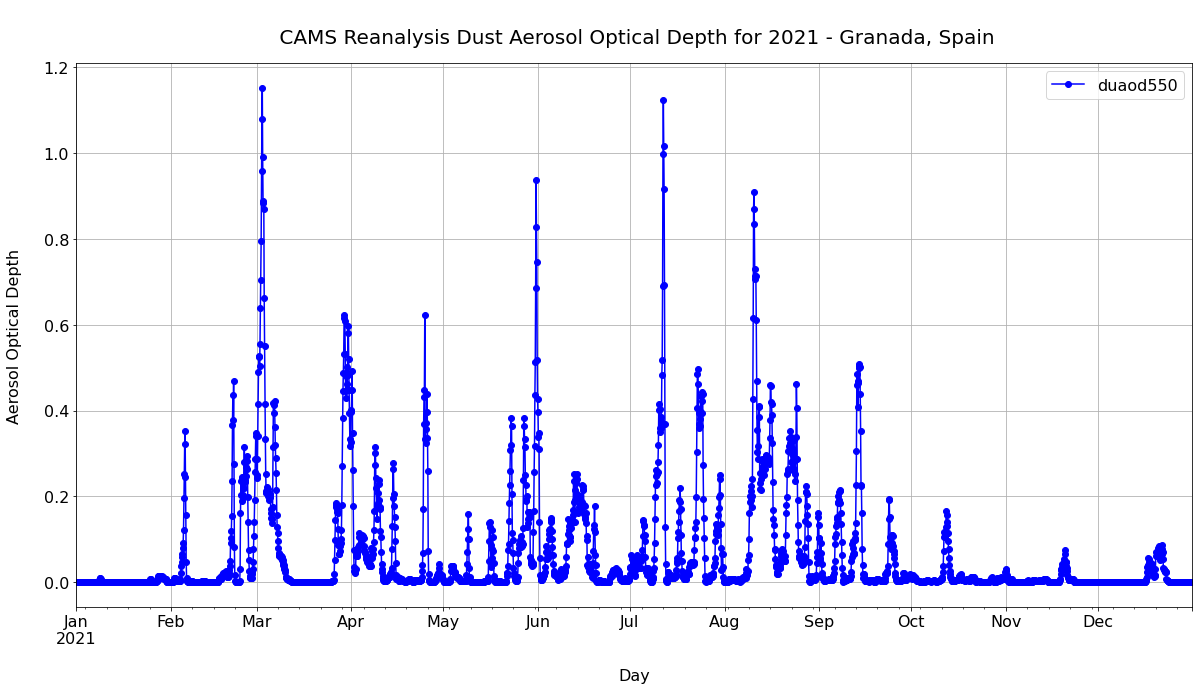

In [17]:
# Initiate a matplotlib figure
fig = plt.figure(figsize=(20,10))
ax=plt.axes()

# Select pandas dataframe columns and define a line plot
cams_ts_df.filter(['duaod550']).plot(ax=ax, style='o-', color='blue' )


# Set title and axes lable information
plt.title('\n CAMS Reanalysis Dust Aerosol Optical Depth for 2021 - Granada, Spain', fontsize=20, pad=20)
plt.ylabel('Aerosol Optical Depth\n', fontsize=16)
plt.xlabel('\nDay', fontsize=16)

# Format the axes ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add additionally a legend and grid to the plot
plt.legend(fontsize=16,loc=0)
plt.grid()

### <a id='aeronet_cams_ts'></a>5. Resample AERONET and CAMS reanalysis (EAC4) time-series for Granada, Spain in 2021 and plot monthly aggregates

From the AERONET dataframe above, let us only select the columns of interest for us. This makes the handling of the dataframe much easier. The columns of interest are: `Time(hh:mm:ss)` and `AOD_500nm` and you can use the function `filter()` to select specific columns.

In [18]:
aeronet_ts = df.filter(['Time(hh:mm:ss)','AOD_500nm'])
aeronet_ts

,Time(hh:mm:ss),AOD_500nm
Date(dd:mm:yyyy),,
01:01:2021,12:00:00,0.051454
02:01:2021,12:00:00,0.045498
03:01:2021,12:00:00,0.039360
04:01:2021,12:00:00,0.057077
05:01:2021,12:00:00,0.056685
...,...,...
14:12:2021,12:00:00,0.044663
15:12:2021,12:00:00,0.050218
16:12:2021,12:00:00,0.079341


The next step is to create an index as `DateTimeIndex`. For this, we want to first combine the index entries (date) and time stamp entries of the column `Time(hh:mm:ss)`. We can do this simply by redefining the data frame's index and combining both with adding the two columns together as a string.

In a second step, we then convert the newly created index entry to a `DateTimeIndex` format with the function `to_datetime()`. Important here, you have to specify the format of combined index string.

In [19]:
aeronet_ts.index = aeronet_ts.index + ' ' + aeronet_ts['Time(hh:mm:ss)']
aeronet_ts.index = pd.to_datetime(aeronet_ts.index, format = '%d:%m:%Y %H:%M:%S')
aeronet_ts

,Time(hh:mm:ss),AOD_500nm
2021-01-01 12:00:00,12:00:00,0.051454
2021-01-02 12:00:00,12:00:00,0.045498
2021-01-03 12:00:00,12:00:00,0.039360
2021-01-04 12:00:00,12:00:00,0.057077
2021-01-05 12:00:00,12:00:00,0.056685
...,...,...
2021-12-14 12:00:00,12:00:00,0.044663
2021-12-15 12:00:00,12:00:00,0.050218
2021-12-16 12:00:00,12:00:00,0.079341
2021-12-18 12:00:00,12:00:00,0.155670


We have to adjust the temporal resolution of the AERONET observations and resample the data frame to monthly temporal resolution. Below, we use the function `resample()` and create the monthly mean. The resulting dataframe has 12 row entries.

In [20]:
aeronet_ts_resample = aeronet_ts.resample('M').mean()
aeronet_ts_resample

,AOD_500nm
2021-01-31,0.060607
2021-02-28,0.121730
2021-03-31,0.222881
2021-04-30,0.135056
2021-05-31,0.105320
2021-06-30,0.131016
2021-07-31,0.253548
2021-08-31,0.261196
2021-09-30,0.127953
2021-10-31,0.104929


Let us do the same for the CAMS global reanalysis data.

In [21]:
cams_ts_df.index = pd.to_datetime(cams_ts_df.index, format='%Y-%m-%d %H:%M:%S')
cams_ts_df

,longitude,latitude,duaod550
time,,,
2021-01-01 00:00:00,-3.25,37.0,0.000034
2021-01-01 03:00:00,-3.25,37.0,0.000034
2021-01-01 06:00:00,-3.25,37.0,0.000034
2021-01-01 09:00:00,-3.25,37.0,0.000034
2021-01-01 12:00:00,-3.25,37.0,0.000034
...,...,...,...
2021-12-31 09:00:00,-3.25,37.0,0.000274
2021-12-31 12:00:00,-3.25,37.0,0.000308
2021-12-31 15:00:00,-3.25,37.0,0.000308


In [22]:
cams_ts_resample = cams_ts_df.resample('M').mean()
cams_ts_resample

,longitude,latitude,duaod550
time,,,
2021-01-31,-3.25,37.0,0.001419
2021-02-28,-3.25,37.0,0.056378
2021-03-31,-3.25,37.0,0.151021
2021-04-30,-3.25,37.0,0.072959
2021-05-31,-3.25,37.0,0.069120
2021-06-30,-3.25,37.0,0.064149
2021-07-31,-3.25,37.0,0.120043
2021-08-31,-3.25,37.0,0.152100
2021-09-30,-3.25,37.0,0.058636


Both time-series (`aeronet_ts_resample` and `cams_ts_resample`) have now the same monthly temporal resolution. The `DateTimeIndex` format allows for an efficient handling of time-series information and also allows us to combine the three time-series into one pandas.DataFrame. We can use the function `join()` and combine the two data frames `aeronet_ts_resample` and `cams_ts_resample`.

The resulting dataframe has 12 row entries and three columns.

In [23]:
df_merged = aeronet_ts_resample.join(cams_ts_resample['duaod550'])
df_merged

,AOD_500nm,duaod550
2021-01-31,0.060607,0.001419
2021-02-28,0.121730,0.056378
2021-03-31,0.222881,0.151021
2021-04-30,0.135056,0.072959
2021-05-31,0.105320,0.069120
2021-06-30,0.131016,0.064149
2021-07-31,0.253548,0.120043
2021-08-31,0.261196,0.152100
2021-09-30,0.127953,0.058636
2021-10-31,0.104929,0.012431


The last step is now to plot the three columns of the pandas.DataFrame `df_merged` as two individual line plots.

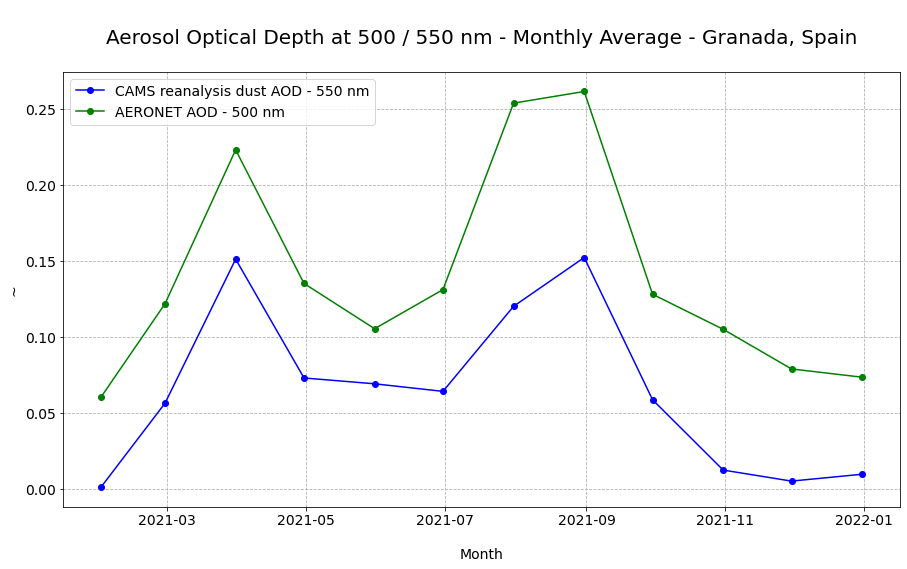

In [38]:
# Initiate a figure
fig = plt.figure(figsize=(15,8))
ax = plt.subplot()

# Define the plotting function
ax.plot(df_merged.duaod550, 'o-', color='blue', label='CAMS reanalysis dust AOD - 550 nm')
ax.plot(df_merged.AOD_500nm, 'o-', color='green', label='AERONET AOD - 500 nm')

# Customize the title and axes lables
ax.set_title('\nAerosol Optical Depth at 500 / 550 nm - Monthly Average - Granada, Spain\n', fontsize=20)
ax.set_ylabel('~', fontsize=14)
ax.set_xlabel('\nMonth', fontsize=14)

# Customize the fontsize of the axes tickes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a gridline to the plot
ax.grid(linestyle='--')

plt.legend(fontsize=14, loc=0)


### <a id='add_iasi_ts'></a> 5. BONUS: Extract a time-series from the Dust AOD monthly gridded C3S aerosol properties data for *Granada, Spain* and add it to the plot.   

#### Load and browse the data from MetOp-C

The xarray `open_mfdataset()` function allows the opening of multiple files at once. You have to specify the dimension the files shall be concatenated by. It can be an existing dimension within the data file or a new dimension, which is newly specified.

Let us open the monthly gridded aerosol optical depth (AOD) data from IASI on MetOp-C for 2021. Recall that we downloaded and used data processed with the LMD (Laboratoire de Météorologie Dynamique) algorithm. We specify `time` as a new dimension that the data files shall be concatenated by. Note: if you want to use the files you downloaded yourself and unzipped, you need to change the filepath in the code cells below.


In [25]:
ds_c = xr.open_mfdataset('../../eodata/dust/part2/1_satellite/iasi_c3s/aod/2021/metop_c/*.nc', 
                         concat_dim='time', 
                         combine='nested')
ds_c

<xarray.Dataset>
Dimensions:                   (Longitude: 360, Latitude: 180, time: 12)
Coordinates:
  * Longitude                 (Longitude) float64 -180.0 -179.0 ... 178.0 179.0
  * Latitude                  (Latitude) float64 -90.0 -89.0 -88.0 ... 88.0 89.0
Dimensions without coordinates: time
Data variables:
    Daod10000                 (time, Latitude, Longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Daod10000_uncertainty     (time, Latitude, Longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Daod11000                 (time, Latitude, Longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Daod550                   (time, Latitude, Longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Mean_dust_layer_altitude  (time, Latitude, Longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/44)
    title:                      Dust Aerosol Optical Depth retrieved from IAS...
    Institution:                Laboratoire de meteorologie dynamique (LMD)
    Source:                     IASI L1C (EUMETSAT)
    History:                    20210310- Product generated from LMD v2.2
    References:                 LMDAERO ATBD issue 2.2
    Tracking_id:                fbfddf53-362e-4df0-9943-61f4d967340b
    ...                         ...
    productID:                  202101-C3S-L3_AEROSOL-D_AOD-IASI-METOPC-LMDAE...
    platform:                   METOPC
    sensor:                     IASI
    spatial_resolution:         12 km diameter pixel at nadir
    content:                    Aerosol Optical Depth
    inputFileList:                  20210101-C3S-L3_AEROSOL-D_AOD-IASI-METOPC...

After you loaded the multiple files in a `Dataset` with the function `open_mfdataset()`, you have to select `Daod550` again as the variable of interest.

The resulting `xarray.DataArray` has three dimensions (`time`, `Latitude` and `Longitude`).

In [26]:
aod_c=ds_c['Daod550']
aod_c

<xarray.DataArray 'Daod550' (time: 12, Latitude: 180, Longitude: 360)>
dask.array<concatenate, shape=(12, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * Longitude  (Longitude) float64 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * Latitude   (Latitude) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
Dimensions without coordinates: time
Attributes:
    units:        None
    long_name:    Dust optical depth at 0.55 microns
    valid_range:  [0.       1.629221]

#### Retrieve  time coordinate information and assign time coordinates for the time dimension

Having coordinates for `time` will be important for plotting the data as we need to know which month the data is valid. Thus, a next step is to assign coordinates to the `time` dimension.

By inspecting the metadata of a single data file `ds_c` we loaded at the beginning, you can see that the metadata attribute `id` contains the date in the name.

The first step is to retrieve the metadata attribute `id` and to split the resulting string object at the positions with a dash `-`. The day string is the first position of the resulting string.

In [27]:
start_month = ds_c.id.split('-')[0]
start_month

'202101'

With the help of the Python library `pandas`, you can build a `DateTime` time series for the three consecutive days, starting from the `start_month` variable that was defined above.

You can use the `date_range` function from pandas, using the length of the time dimension of the `ds_c` DataArray and `'m'` (for month) as freqency argument. Note that `202101` is in the format `%Y%m`.

The result is a time-series with `DateTime` information from 1 January 2021 to 1 October 2021.

In [28]:
time_coords_c = pd.date_range(datetime.strptime(start_month,'%Y%m'), periods=len(ds_c.time), freq='m').strftime("%Y-%m").astype('datetime64[ns]')
time_coords_c

DatetimeIndex(['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', freq=None)

<br>

The final step is to assign the pandas time series object `time_coords` to the `aod_c` DataArray object, You can use the `assign_coords()` function from xarray.

The result is that the time coordinates have now been assigned values. 

In [29]:
aod_c = aod_c.assign_coords(time=time_coords_c)
aod_c

<xarray.DataArray 'Daod550' (time: 12, Latitude: 180, Longitude: 360)>
dask.array<concatenate, shape=(12, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * Longitude  (Longitude) float64 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * Latitude   (Latitude) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
  * time       (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
Attributes:
    units:        None
    long_name:    Dust optical depth at 0.55 microns
    valid_range:  [0.       1.629221]

From the loaded xarray data array `aod_c`, we can now select the values for one specific point location. We can select coordinate information with the function `sel()`. We have to make sure to set the keyword argument `method='nearest'`. With this keyword argument, the closest grid location in the data array is used for the time-series retrieval.

In [30]:
c3s_ts = aod_c.sel(Longitude=lon, Latitude=lat, method='nearest')
c3s_ts

<xarray.DataArray 'Daod550' (time: 12)>
dask.array<getitem, shape=(12,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    Longitude  float64 -4.0
    Latitude   float64 37.0
  * time       (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
Attributes:
    units:        None
    long_name:    Dust optical depth at 0.55 microns
    valid_range:  [0.       1.629221]

<br>

Time-series information is better to handle via the Python library [Pandas](https://pandas.pydata.org/). You can use the function `to_dataframe()` to convert a xarray.DataArray into a pandas.DataFrame.

In [31]:
c3s_ts_df = c3s_ts.to_dataframe()
c3s_ts_df

,Longitude,Latitude,Daod550
time,,,
2021-01-01,-4.0,37.0,0.043568
2021-02-01,-4.0,37.0,0.106125
2021-03-01,-4.0,37.0,0.093216
2021-04-01,-4.0,37.0,0.109722
2021-05-01,-4.0,37.0,0.060240
2021-06-01,-4.0,37.0,0.080486
2021-07-01,-4.0,37.0,0.176226
2021-08-01,-4.0,37.0,0.146545
2021-09-01,-4.0,37.0,0.055307


Although the `c3s_ts_df` dataframe already has a monthly resolution, we need to resample it again so that the time index matches that of the `df_merged` dataframe.

In [32]:
c3s_ts_resample = c3s_ts_df.resample('M').mean()
c3s_ts_resample

,Longitude,Latitude,Daod550
time,,,
2021-01-31,-4.0,37.0,0.043568
2021-02-28,-4.0,37.0,0.106125
2021-03-31,-4.0,37.0,0.093216
2021-04-30,-4.0,37.0,0.109722
2021-05-31,-4.0,37.0,0.060240
2021-06-30,-4.0,37.0,0.080486
2021-07-31,-4.0,37.0,0.176226
2021-08-31,-4.0,37.0,0.146545
2021-09-30,-4.0,37.0,0.055307


The next step is to join `c3s_ts_resample` to the earlier `df_merged` dataframe which contains the AERONET and CAMS reanalysis data.

In [33]:
df_merged2 = df_merged.join(c3s_ts_resample['Daod550'])
df_merged2

,AOD_500nm,duaod550,Daod550
2021-01-31,0.060607,0.001419,0.043568
2021-02-28,0.121730,0.056378,0.106125
2021-03-31,0.222881,0.151021,0.093216
2021-04-30,0.135056,0.072959,0.109722
2021-05-31,0.105320,0.069120,0.060240
2021-06-30,0.131016,0.064149,0.080486
2021-07-31,0.253548,0.120043,0.176226
2021-08-31,0.261196,0.152100,0.146545
2021-09-30,0.127953,0.058636,0.055307
2021-10-31,0.104929,0.012431,0.030479


Finally, plot all three time-series on the same plot.

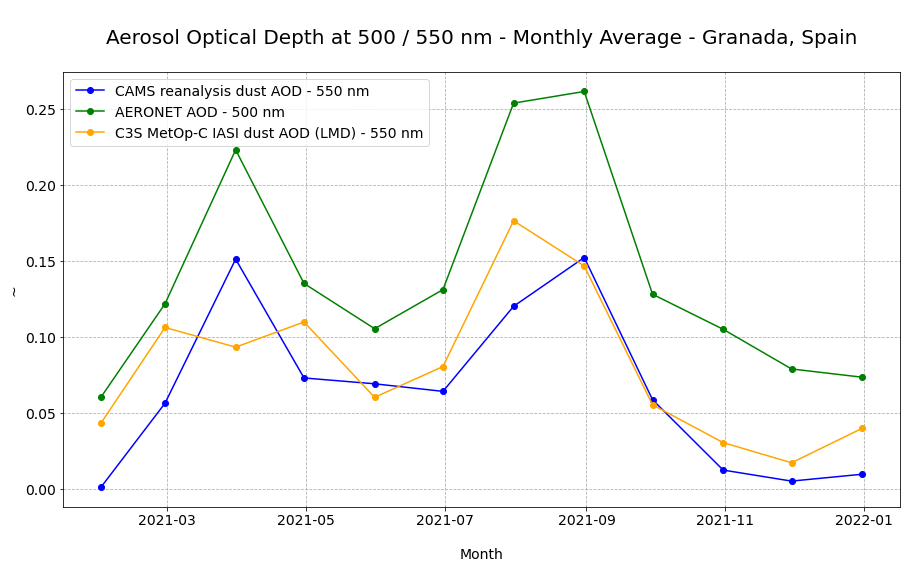

In [35]:
# Initiate a figure
fig = plt.figure(figsize=(15,8))
ax = plt.subplot()

# Define the plotting function
ax.plot(df_merged2.duaod550, 'o-', color='blue', label='CAMS reanalysis dust AOD - 550 nm')
ax.plot(df_merged2.AOD_500nm, 'o-', color='green', label='AERONET AOD - 500 nm')
ax.plot(df_merged2.Daod550, 'o-', color='orange', label='C3S MetOp-C IASI dust AOD (LMD) - 550 nm')

# Customize the title and axes lables
ax.set_title('\nAerosol Optical Depth at 500 / 550 nm - Monthly Average - Granada, Spain\n', fontsize=20)
ax.set_ylabel('~', fontsize=14)
ax.set_xlabel('\nMonth', fontsize=14)

# Customize the fontsize of the axes tickes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a gridline to the plot
ax.grid(linestyle='--')

plt.legend(fontsize=14, loc=0)


<hr>

<img src='../img/copernicus_logo.png' alt='Logo EU Copernicus' align='left' width='20%'><br><br><br><br>
This project is licensed under <a href="../../LICENSE">GNU General Public License v3.0 only</a> and is developed under a Copernicus contract.

<p style="text-align:right;"> <a href='https://training.eumetsat.int'>EUMETSAT Training</a> | <a href='mailto:training@eumetsat.int'>Contact the training team</a></p>